# About this assignment.
1. I've implemented Normalised LMS in the assignment 2 notebook.
2. ```Can you change the data/use completely other data so that normalisation actually ‘kicks in’ and becomes a welcome addition to the family of LMS algorithms```</br>
This is something that can be heard using the audio file. You can really hear the filter work and slowly kick into gear after a second.
3. ```If you try to run the normal LMS on the new data set, do problems start to arise due to the relatively large values that you encounter?``` </br>
I added a section below the audio filter, with one large and one small sine wave added together. You can clearly see that with the previous LMS and the same learning rate, the filter is completely over correcting. While with the normalised LMS it is working perfectly fine. The normalise LMS actually also works better than the previous LMS for the audio.
4. Optional 1 and partialy Optional 2 are also in this notebook. These are combined in the end of the notebook.

# 1. Normalised LMS with assignment 2 

# Osciliations of the platform

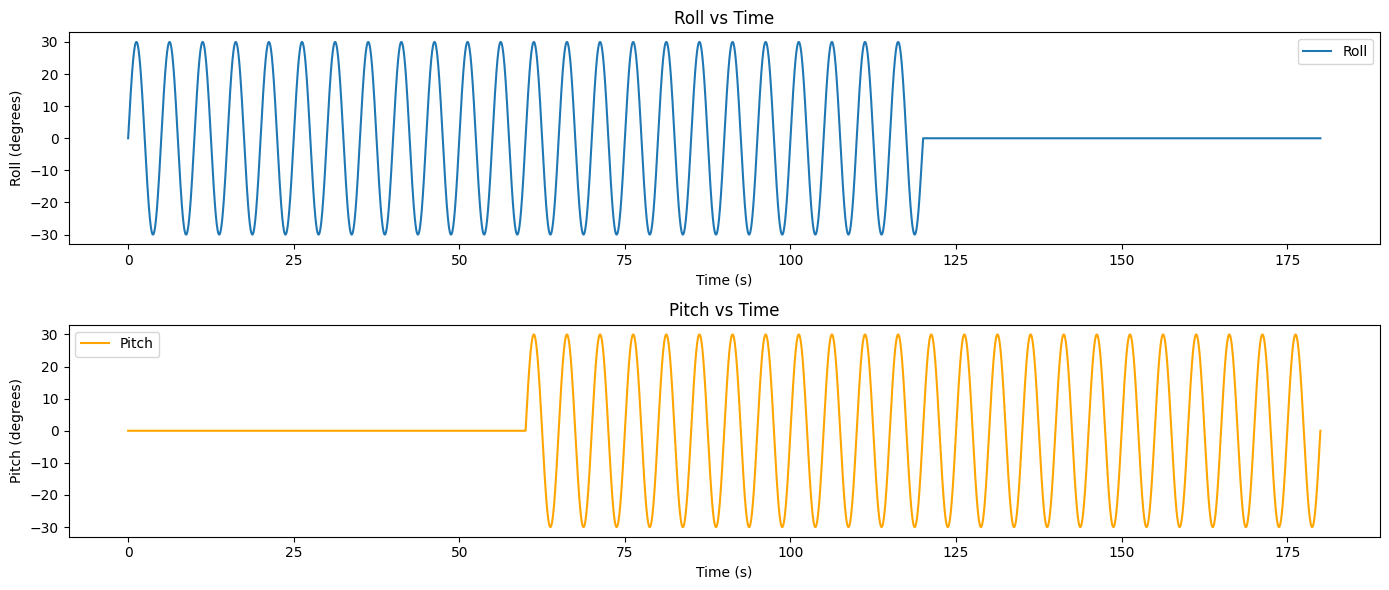

In [2]:
import numpy as np
import matplotlib.pyplot as plt

frequency = 0.2
cycle_time = 1/ frequency
a = 2 * np.pi / cycle_time

n_cycles = 12
t_roll = n_cycles * cycle_time

t_pause = 0

t_total = 4 * t_pause + 3 * (n_cycles * cycle_time)

def roll(t, t_pause, t_roll, a):
    if t < t_pause:
        return 0 
    if t < t_pause + t_roll:
        return 30 * np.sin(a * t)
    if t < 2 * t_pause + t_roll:
        return 0
    if t < 2 * (t_pause + t_roll):
        return 30 * np.sin(a * t)
    return  0

def pitch(t, t_pause, t_roll, a):
    if t < 2 * t_pause + t_roll:
        return 0
    if t < 2 * (t_pause + t_roll):
        return 30 * np.sin(a * t)
    if t < 3 * t_pause + 2 * t_roll:
        return 0
    if t < 3 * (t_pause + t_roll):
        return 30 * np.sin(a * t)
    return 0

sample_time = t_total
sample_frequency = 100
total_samples = sample_time * sample_frequency

time = np.linspace(0, t_total, int(total_samples))

# Calculate roll and pitch arrays
roll_array = np.array([roll(t, t_pause, t_roll, a) for t in time])
pitch_array = np.array([pitch(t, t_pause, t_roll, a) for t in time])

plt.figure(figsize=(14, 6))

# Plot roll_array
plt.subplot(2, 1, 1)
plt.plot(time, roll_array, label='Roll')
plt.xlabel('Time (s)')
plt.ylabel('Roll (degrees)')
plt.title('Roll vs Time')
plt.legend()

# Plot pitch_array
plt.subplot(2, 1, 2)
plt.plot(time, pitch_array, label='Pitch', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (degrees)')
plt.title('Pitch vs Time')
plt.legend()

plt.tight_layout()
plt.show()

# Model the accuracy of the accelerometers

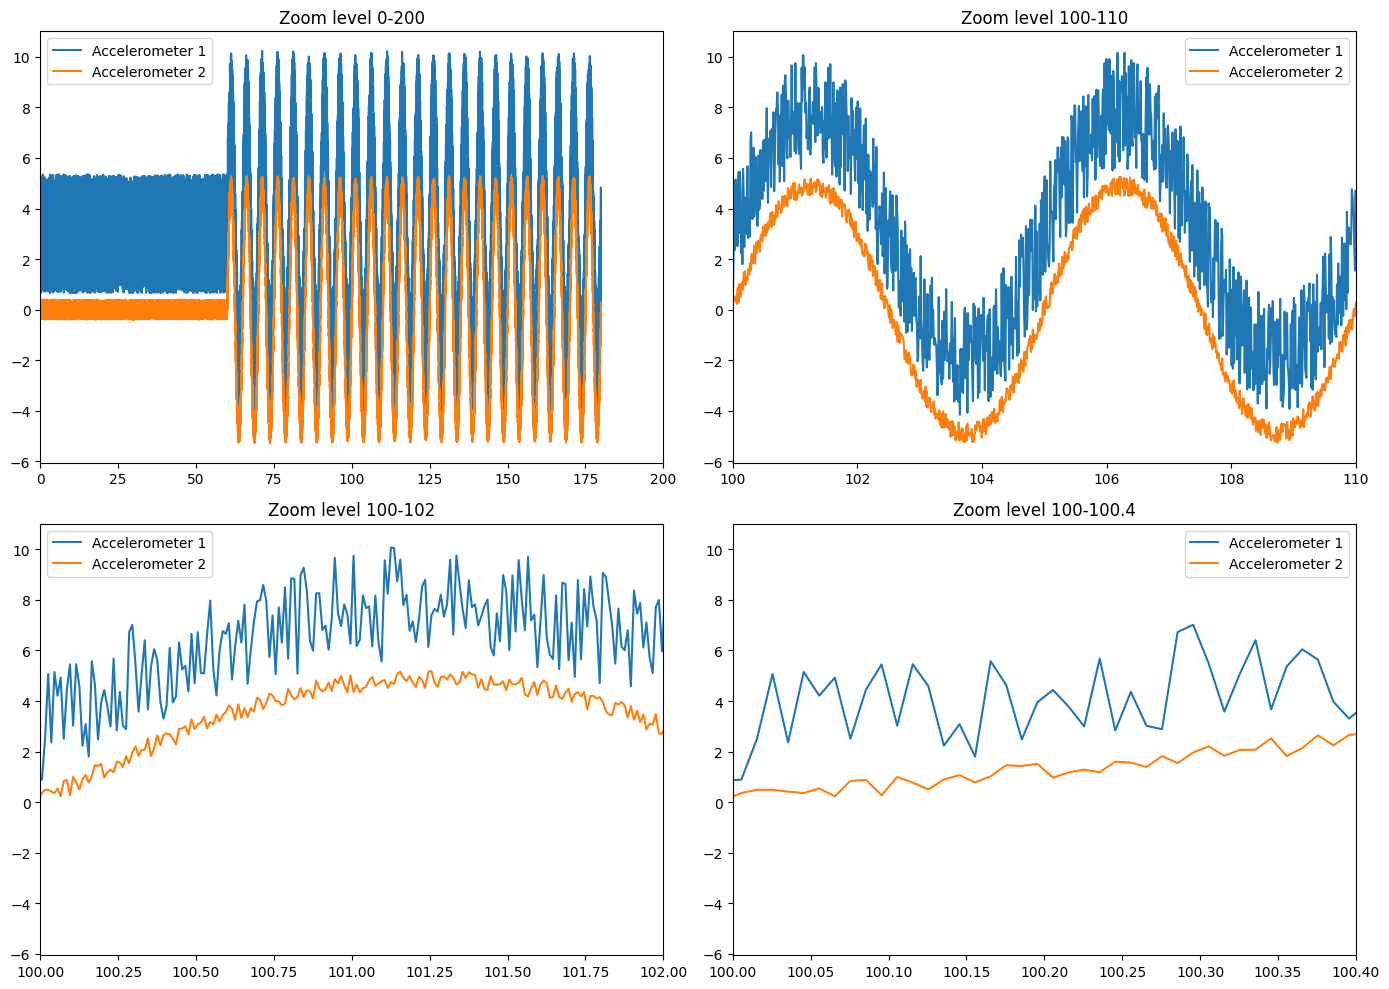

In [3]:
gravity = 9.807
accel_x = gravity * np.sin(pitch_array * np.pi/180)
accel_max_measurement = 8 * gravity

accelerometer_1 = 0.03 * accel_max_measurement
accelerometer_2 = 0.005 * accel_max_measurement
accel_offset_1 = 3
accel_offset_2 = 0

m_accel_x_1 = accel_x + accel_offset_1 + (1 - (2 * np.random.rand(len(accel_x)))) * accelerometer_1
m_accel_x_2 = accel_x + accel_offset_2 + (1 - (2 * np.random.rand(len(accel_x)))) * accelerometer_2

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Zoom level 0-200
axs[0, 0].plot(time, m_accel_x_1, label='Accelerometer 1')
axs[0, 0].plot(time, m_accel_x_2, label='Accelerometer 2')
axs[0, 0].set_xlim(0, 200)
axs[0, 0].set_title('Zoom level 0-200')
axs[0, 0].legend()

# Plot 2: Zoom level 100-110
axs[0, 1].plot(time, m_accel_x_1, label='Accelerometer 1')
axs[0, 1].plot(time, m_accel_x_2, label='Accelerometer 2')
axs[0, 1].set_xlim(100, 110)
axs[0, 1].set_title('Zoom level 100-110')
axs[0, 1].legend()

# Plot 3: Zoom level 100-102
axs[1, 0].plot(time, m_accel_x_1, label='Accelerometer 1')
axs[1, 0].plot(time, m_accel_x_2, label='Accelerometer 2')
axs[1, 0].set_xlim(100, 102)
axs[1, 0].set_title('Zoom level 100-102')
axs[1, 0].legend()

# Plot 4: Zoom level 100-100.4
axs[1, 1].plot(time, m_accel_x_1, label='Accelerometer 1')
axs[1, 1].plot(time, m_accel_x_2, label='Accelerometer 2')
axs[1, 1].set_xlim(100, 100.4)
axs[1, 1].set_title('Zoom level 100-100.4')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Normalised LMS adaptive filter
Update weights with w(k+1) = w(k) + μ * e(k) * x

Final weights (w): [0.17036151 0.17016186 0.16910309 0.16376795 0.15306539 0.1538093 ]
First 10 filtered values (y): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
First 10 errors (e): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


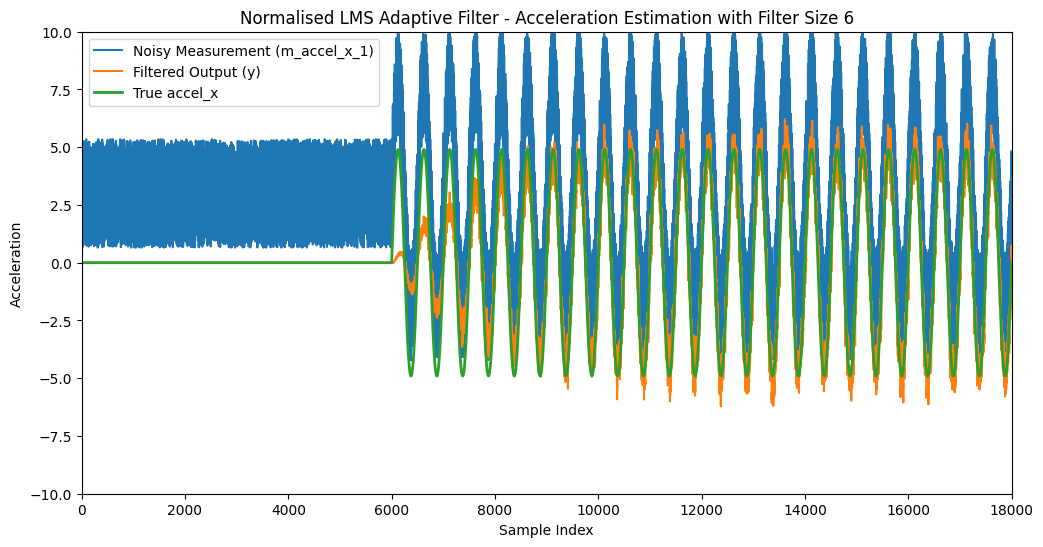

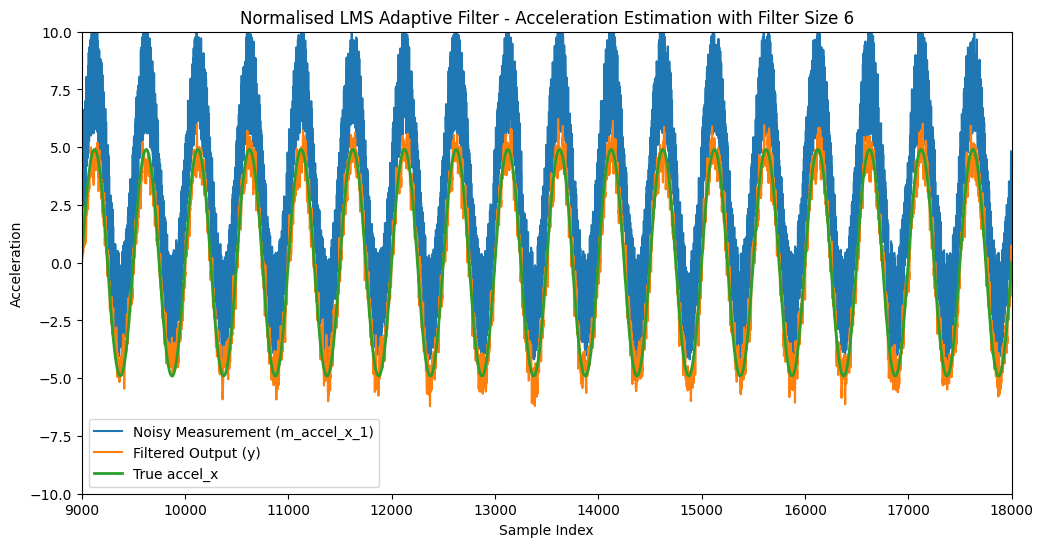

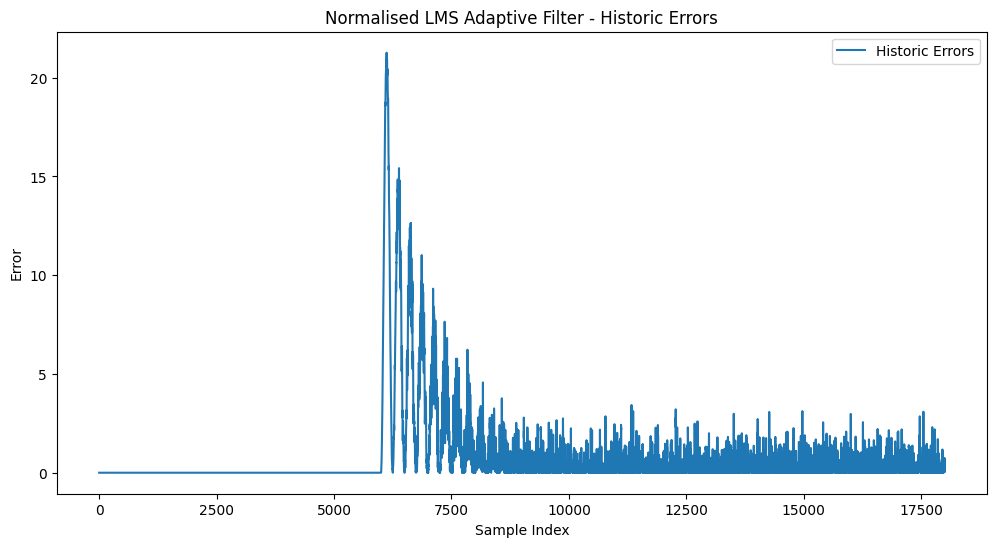

In [4]:
average_1 = np.mean(m_accel_x_1)
average_2 = np.mean(m_accel_x_2)

m_accel_x_centered_1 = m_accel_x_1 - average_1


filter_size = 6
learning_rate = 0.0001
# Initialize weights (w) as a vector of zeros with length equal to filter size

def test_filter(filter_size, learning_rate, m_accel_x_centered_1, accel_x):
    # Arrays to store results
    y_array = np.zeros(len(accel_x))     # Filtered outputs
    error_array = np.zeros(len(accel_x)) # Errors
    
    w = np.zeros(filter_size)
    # Initialize input buffer with zeros to hold the last `filter_size` inputs
    input_buffer = np.zeros(filter_size)

    historic_errors = []
    # LMS adaptation loop
    for k in range(len(m_accel_x_centered_1)):
        # Update input buffer with the current measurement
        input_buffer = np.roll(input_buffer, -1)  # Shift left
        input_buffer[-1] = m_accel_x_centered_1[k]         # Add new measurement at the end

        # Desired output at this time step
        d_k = accel_x[k]

        # Calculate the output y(k) = w.T * x (dot product of weights and input buffer)
        y_k = np.dot(w, input_buffer)

        # Calculate the error e(k) = d(k) - y(k)
        e_k = (d_k - y_k)

        # Update weights with w(k+1) = w(k) + μ * e(k) * x
        w += (learning_rate/ (1e-3 + (abs(input_buffer) ** 2)))* e_k * input_buffer

        # Store results
        y_array[k] = y_k
        error_array[k] = e_k

        historic_errors.append(e_k ** 2)

    # Display final weights and a sample of the filtered output
    print("Final weights (w):", w)
    print("First 10 filtered values (y):", y_array[:10])
    print("First 10 errors (e):", error_array[:10])
    return y_array, historic_errors

# for i in range(4, 10):
# learning_rate = 10 ** -i
y_array,  historic_errors = test_filter(filter_size, learning_rate, m_accel_x_centered_1, accel_x)
# Plot results to visualize the filtering process
plt.figure(figsize=(12, 6))
plt.plot(m_accel_x_1, label='Noisy Measurement (m_accel_x_1)')
plt.plot(y_array, label='Filtered Output (y)')
plt.plot(accel_x, label='True accel_x', linewidth=2)
plt.xlim(0, 18000)
plt.ylim(-10, 10)
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Acceleration')
plt.title('Normalised LMS Adaptive Filter - Acceleration Estimation with Filter Size 6')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(m_accel_x_1, label='Noisy Measurement (m_accel_x_1)')
plt.plot(y_array, label='Filtered Output (y)')
plt.plot(accel_x, label='True accel_x', linewidth=2)
plt.xlim(9000, 18000)
plt.ylim(-10, 10)
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Acceleration')
plt.title('Normalised LMS Adaptive Filter - Acceleration Estimation with Filter Size 6')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(historic_errors, label='Historic Errors')
plt.xlabel('Sample Index')
plt.ylabel('Error')
plt.title('Normalised LMS Adaptive Filter - Historic Errors')
plt.legend()
plt.show()


# Part 2
## the images

(315, 560)


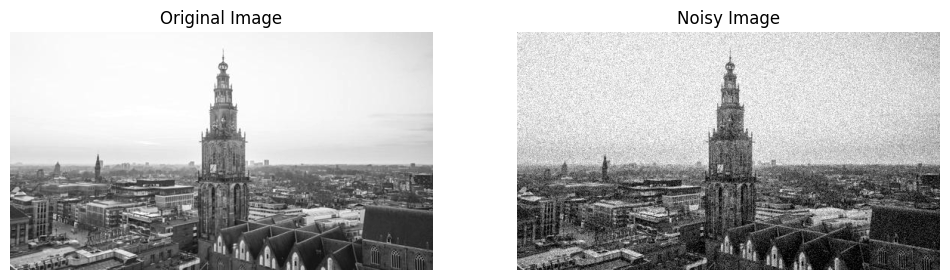

In [5]:
from PIL import Image
import IPython.display as display

# Load the image
image = Image.open('test_image_bw.jpg')

raw_image = np.array(image)
print(raw_image.shape)
desired_image = raw_image - np.mean(raw_image)
noise_level = 20
noise = np.random.normal(-noise_level, noise_level, desired_image.shape)
noisy_image = raw_image + noise

# Convert noisy_image to uint8 and clip values to be in the valid range [0, 255]
noisy_image_uint8 = np.clip(noisy_image, 0, 255).astype(np.uint8)

input_image = desired_image + noise

# Display the image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(noisy_image_uint8, cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

plt.show()
# # Resize the image by 70%
# width, height = image.size
# new_size = (int(width * 0.5), int(height * 0.5))
# resized_image = image.resize(new_size)

# # Convert the image to black and white
# bw_image = resized_image.convert('L')

# # Save the black and white image
# bw_image.save('test_image_bw.jpg')

In [6]:
def mirror_alternate_rows(image):
    img_array = np.array(image)
    
    # Get the height and width of the image
    height, width = img_array.shape
    
    # Mirror every other row starting from the second row
    for row in range(1, height, 2):
        img_array[row] = img_array[row][::-1]
    
    # Convert the modified array back to an image
    # mirrored_img = Image.fromarray(img_array)
    return img_array

def lms_filter_1d(input_image, desired_image, filter_size=3, learning_rate=0.01, start_weights=None, Alternate=True):
    if start_weights is not None:
        weights = start_weights
    else:
        weights = np.zeros(filter_size)
    
    if Alternate:
        input_image = mirror_alternate_rows(input_image)
        desired_image = mirror_alternate_rows(desired_image)
    
    if len(input_image.shape) > 1:
        error_history = np.zeros(input_image.shape[0] * input_image.shape[1])
    else:
        error_history = np.zeros(len(input_image))
        
    output_weights = None
    
    input_flat = input_image.flatten()
    desired_flat = desired_image.flatten()
    output_image_flat = np.zeros_like(input_flat)
    input_buffer = np.zeros(filter_size)
    
    for i in range(len(input_flat)):
        # Update input buffer with the current measurement
        input_buffer = np.roll(input_buffer, -1)  # Shift left
        input_buffer[-1] = input_flat[i]         # Add new measurement at the end

        # Desired output at this time step
        d_k = desired_flat[i]

        # Calculate the output y(k) = w.T * x (dot product of weights and input buffer)
        y_k = np.dot(weights, input_buffer)

        # Calculate the error e(k) = d(k) - y(k)
        e_k = (d_k - y_k)

        if e_k < 10 and output_weights is None:
               output_weights = weights
           
        if abs(e_k) < 1e-10:
            if e_k > 0:
                e_k = 0.1e-10
            else:
                e_k = -0.1e-10
        
        if abs(e_k) > 1e150:
            if e_k > 0:
                e_k = 1e150
            else:
                e_k = -1e150
                
        # Update weights with w(k+1) = w(k) + μ * e(k) * x
        # weights += learning_rate * e_k * input_buffer
        weights += (learning_rate/ (1e-3 + (abs(input_buffer) ** 2)))* e_k * input_buffer
        # Store results
        output_image_flat[i] = y_k
        error_history[i] = e_k ** 2

    if len(input_image.shape) > 1:
        return mirror_alternate_rows(np.reshape(output_image_flat, (input_image.shape[0], input_image.shape[1]))), error_history, output_weights 
    else:
        return output_image_flat, error_history, output_weights

    # instead of using a 1D filter, we will use a 2D filter with a square window
def lms_filter_2d(input_image, desired_image, filter_size=3, learning_rate=0.01, start_weights=None, print_error=False, update_weights=True):
    """
    Apply LMS filtering on a 2D image with a given filter size and learning rate.

    Parameters:
    - input_image (2D array): Noisy or raw input image.
    - desired_image (2D array): Target or desired output image (e.g., clean version).
    - filter_size (int): Size of the square filter window (e.g., 3 for a 3x3 window).
    - learning_rate (float): Learning rate for the LMS algorithm.

    Returns:
    - output_image (2D array): Filtered output image.
    - error_image (2D array): Error image showing the error at each pixel.
    """
    # Initialize filter weights (e.g., zeros) with shape (filter_size, filter_size)
    if start_weights is not None:
        weights = start_weights
    else:
        weights = np.zeros((filter_size, filter_size))

    # Padding size for the image borders
    pad_size = filter_size // 2
    padded_input = np.pad(input_image, pad_size, mode='constant', constant_values=0)

    # Prepare output images
    output_image = np.zeros_like(input_image)
    error_history = np.zeros(input_image.shape[0] * input_image.shape[1])
    output_weights = None

    # Loop over each pixel in the input image (excluding padding)
    for i in range(pad_size, padded_input.shape[0] - pad_size):
        # Determine the order of columns for this row (left to right or right to left)
        if (i - pad_size) % 2 == 0:  # Even row: left to right
            column_range = range(pad_size, padded_input.shape[1] - pad_size)
        else:  # Odd row: right to left
            column_range = range(padded_input.shape[1] - pad_size - 1, pad_size - 1, -1)

        for j in column_range:
            # Extract the current filter window (input buffer)
            input_buffer = padded_input[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1]

            # Desired output (target pixel value)
            d_k = desired_image[i - pad_size, j - pad_size]

            # Calculate the output y(k) = sum(weights * input_buffer)
            # Instead of using np.dot, we can flatten the arrays and use np.sum
            y_k = np.sum(weights * input_buffer)

            # Calculate the error e(k) = d(k) - y(k)
            e_k = d_k - y_k
            if e_k < 10 and output_weights is None:
                output_weights = weights
            
            if abs(e_k) < 1e-10:
                if e_k > 0:
                    e_k = 0.1e-10
                else:
                    e_k = -0.1e-10
            
            if abs(e_k) > 1e150:
                if e_k > 0:
                    e_k = 1e150
                else:
                    e_k = -1e150

            with np.errstate(invalid='raise'):
                try:
                    # Update weights with LMS rule: w(k+1) = w(k) + μ * e(k) * input_buffer
                    if update_weights:
                        previous_weights = weights
                        # weights += learning_rate * e_k * input_buffer
                        weights += (learning_rate/ (1e-3 + (abs(input_buffer) ** 2)))* e_k * input_buffer
                except:
                    if print_error:
                        print("Error at ", i, j)
                        print("weights", weights)
                        print("learning_rate", learning_rate)
                        print("e_k", e_k)
                        print("input_buffer", input_buffer)
                        print("d_k", d_k)
                        print("y_k", y_k)
                        print("previous_weights", previous_weights)

            # Store the output and error in their respective images
            output_image[i - pad_size, j - pad_size] = y_k
            error_history[(i - pad_size) * input_image.shape[1] + (j - pad_size)] = e_k ** 2
    return output_image, error_history, output_weights 

# Using a 1 dimensional filter

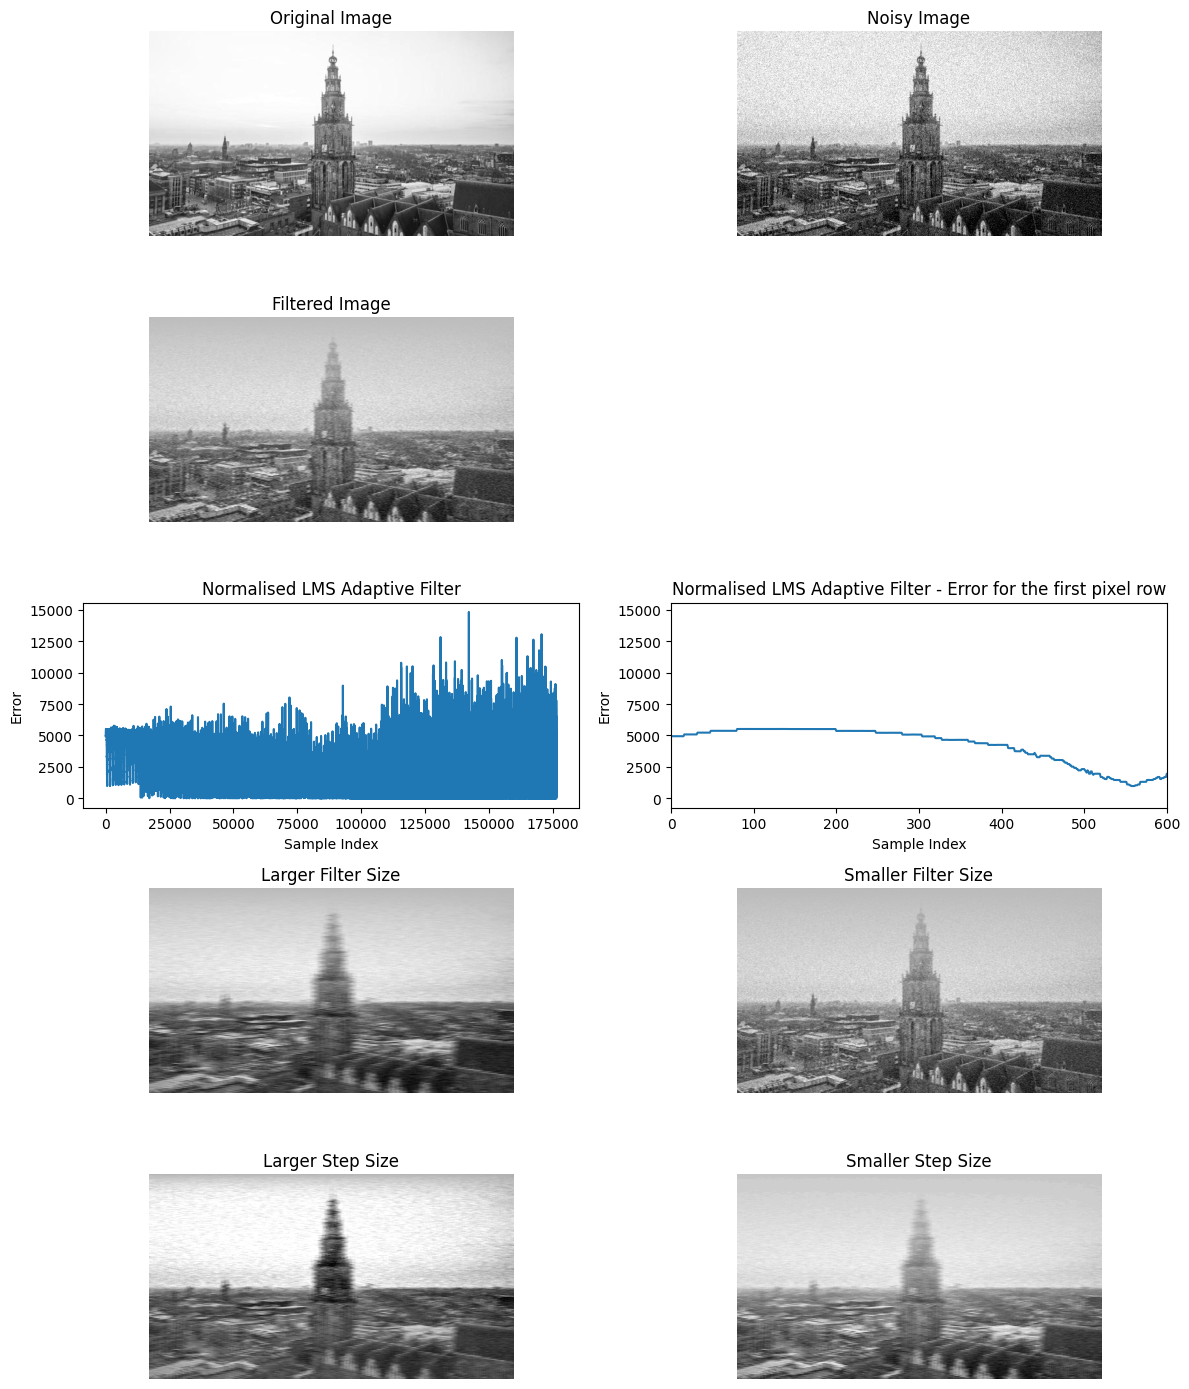

In [7]:
filtered_image, error_history, weights = lms_filter_1d(input_image, desired_image, 3, 0.000001, None)
larger_step, _,_ = lms_filter_1d(input_image, desired_image, 7, 0.00001, None, True)
smaller_step, _,_ = lms_filter_1d(input_image, desired_image, 7, 0.0000001, None)
larger_filter, _,_ = lms_filter_1d(input_image, desired_image, 9, 0.000001, None)
smaller_filter, _,_ = lms_filter_1d(input_image, desired_image, 2, 0.000001, None)

# Reshape the output to the original image shape
output_image = filtered_image.reshape(raw_image.shape)
output_image += np.mean(raw_image)
# Clip values to be in the valid range [0, 255] and convert to uint8
output_image_uint8 = np.clip(output_image, 0, 255).astype(np.uint8)

larger_step = larger_step.reshape(raw_image.shape)
larger_step += np.mean(raw_image)
larger_step = np.clip(larger_step, 0, 255).astype(np.uint8)

smaller_step = smaller_step.reshape(raw_image.shape)
smaller_step += np.mean(raw_image)
smaller_step = np.clip(smaller_step, 0, 255).astype(np.uint8)

larger_filter = larger_filter.reshape(raw_image.shape)
larger_filter += np.mean(raw_image)
larger_filter = np.clip(larger_filter, 0, 255).astype(np.uint8)

smaller_filter = smaller_filter.reshape(raw_image.shape)
smaller_filter += np.mean(raw_image)
smaller_filter = np.clip(smaller_filter, 0, 255).astype(np.uint8)

# Display the original, noisy, and output images
fig, ax = plt.subplots(5, 2, figsize=(12, 14))
ax[0, 0].imshow(raw_image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_uint8, cmap='gray')
ax[0, 1].set_title('Noisy Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(output_image_uint8, cmap='gray')
ax[1, 0 ].set_title('Filtered Image')
ax[1, 0].axis('off')

ax[1, 1].axis('off')

ax[2, 0].plot(error_history, label='Errors')
ax[2, 0].set_xlabel('Sample Index')
ax[2, 0].set_ylabel('Error')
ax[2, 0].set_title('Normalised LMS Adaptive Filter')

ax[2, 1].plot(error_history, label='Errors')
ax[2, 1].set_xlabel('Sample Index')
ax[2, 1].set_ylabel('Error')
ax[2, 1].set_title('Normalised LMS Adaptive Filter - Error for the first pixel row')
ax[2, 1].set_xlim(0, 600)

# Plot larger_filter
ax[3, 0].imshow(larger_filter, cmap='gray')
ax[3, 0].set_title('Larger Filter Size')
ax[3, 0].axis('off')

# Plot smaller_filter
ax[3, 1].imshow(smaller_filter, cmap='gray')
ax[3, 1].set_title('Smaller Filter Size')
ax[3, 1].axis('off')

# Plot larger_step
ax[4, 0].imshow(larger_step, cmap='gray')
ax[4, 0].set_title('Larger Step Size')
ax[4, 0].axis('off')

# Plot smaller_step
ax[4, 1].imshow(smaller_step, cmap='gray')
ax[4, 1].set_title('Smaller Step Size')
ax[4, 1].axis('off')

fig.tight_layout()
plt.show()


# Using a 2D filter
This filter will still zig-zag across the image. 

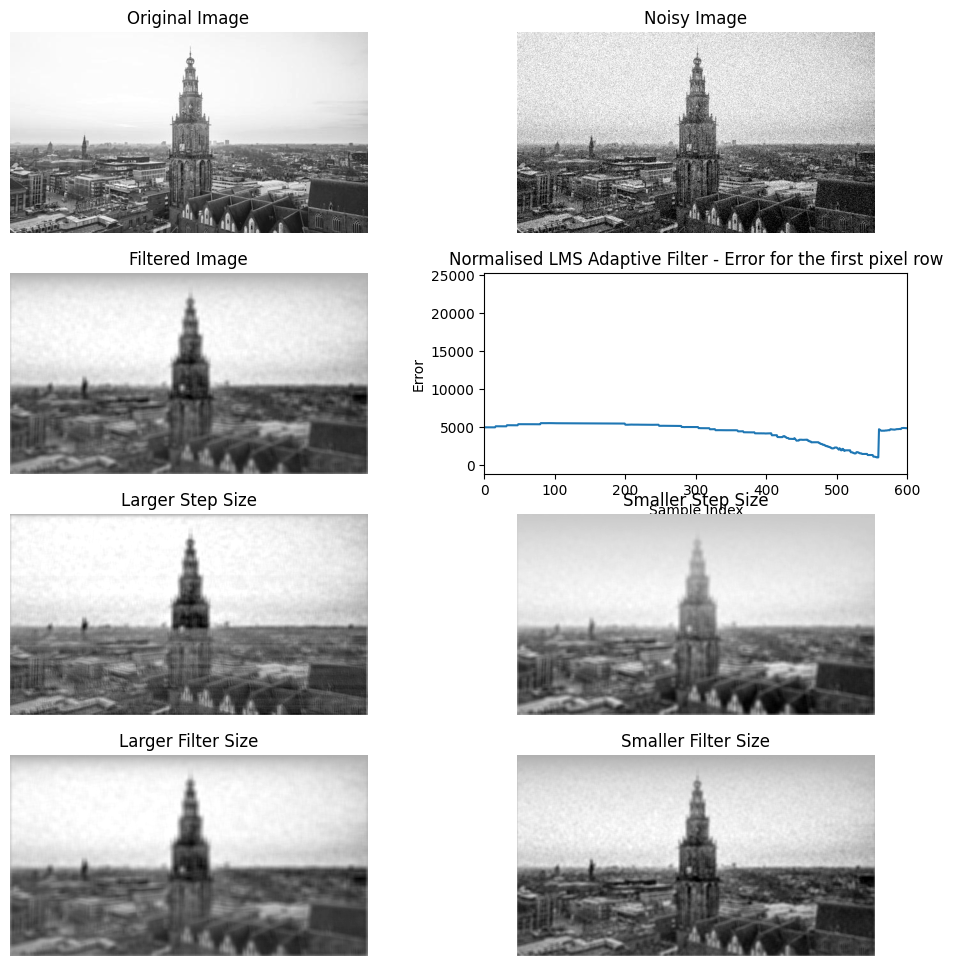

In [8]:
# weights, output, errors = lms_training(input_image, desired_image, 10, 0.00001, 560)
filtered_image, error_history, weights = lms_filter_2d(input_image, desired_image, 7, 0.000001, None)
larger_step, _,_ = lms_filter_2d(input_image, desired_image, 7, 0.00001, None, True)
smaller_step, _,_ = lms_filter_2d(input_image, desired_image, 7, 0.0000001, None)
larger_filter, _,_ = lms_filter_2d(input_image, desired_image, 9, 0.000001, None)
smaller_filter, _,_ = lms_filter_2d(input_image, desired_image, 5, 0.000001, None)

# Reshape the output to the original image shape
output_image = filtered_image.reshape(raw_image.shape)
output_image += np.mean(raw_image)
# Clip values to be in the valid range [0, 255] and convert to uint8
output_image_uint8 = np.clip(output_image, 0, 255).astype(np.uint8)

larger_step = larger_step.reshape(raw_image.shape)
larger_step += np.mean(raw_image)
larger_step = np.clip(larger_step, 0, 255).astype(np.uint8)

smaller_step = smaller_step.reshape(raw_image.shape)
smaller_step += np.mean(raw_image)
smaller_step = np.clip(smaller_step, 0, 255).astype(np.uint8)

larger_filter = larger_filter.reshape(raw_image.shape)
larger_filter += np.mean(raw_image)
larger_filter = np.clip(larger_filter, 0, 255).astype(np.uint8)

smaller_filter = smaller_filter.reshape(raw_image.shape)
smaller_filter += np.mean(raw_image)
smaller_filter = np.clip(smaller_filter, 0, 255).astype(np.uint8)

# Display the original, noisy, and output images
fig, ax = plt.subplots(4, 2, figsize=(12, 12))
ax[0, 0].imshow(raw_image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_uint8, cmap='gray')
ax[0, 1].set_title('Noisy Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(output_image_uint8, cmap='gray')
ax[1, 0 ].set_title('Filtered Image')
ax[1, 0].axis('off')

ax[1, 1].plot(error_history, label='Errors')
ax[1, 1].set_xlabel('Sample Index')
ax[1, 1].set_ylabel('Error')
ax[1, 1].set_title('Normalised LMS Adaptive Filter - Error for the first pixel row')
ax[1, 1].set_xlim(0, 600)

# Plot larger_step
ax[2, 0].imshow(larger_step, cmap='gray')
ax[2, 0].set_title('Larger Step Size')
ax[2, 0].axis('off')

# Plot smaller_step
ax[2, 1].imshow(smaller_step, cmap='gray')
ax[2, 1].set_title('Smaller Step Size')
ax[2, 1].axis('off')

# Plot larger_filter
ax[3, 0].imshow(larger_filter, cmap='gray')
ax[3, 0].set_title('Larger Filter Size')
ax[3, 0].axis('off')

# Plot smaller_filter
ax[3, 1].imshow(smaller_filter, cmap='gray')
ax[3, 1].set_title('Smaller Filter Size')
ax[3, 1].axis('off')

plt.show()


# Checking execution time with increasing filter size
The correlation seems to be linear

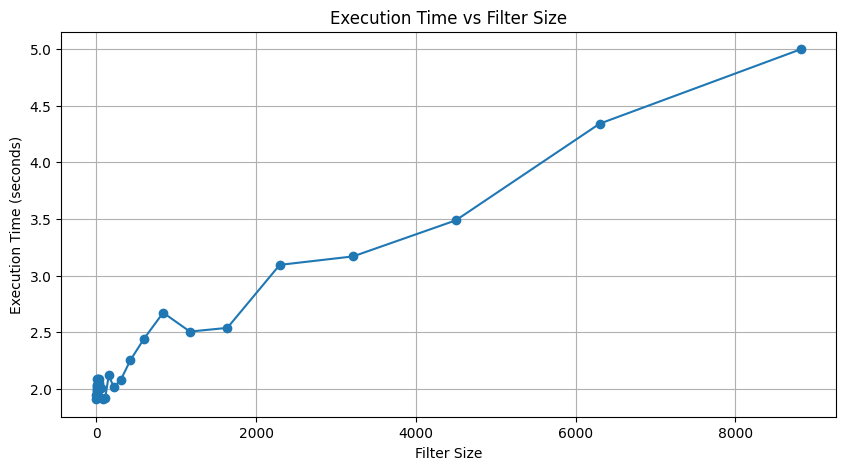

In [9]:
import time

itterations = 28 # 
execution_times = []
x_values = []
for i in range(itterations):
    start_time = time.time()
    filter_size = round(1.4 ** i)
    if filter_size in x_values:
        continue
    filtered_image, error_history, weights = lms_filter_1d(input_image, desired_image, filter_size, 0.000001, None)
    end_time = time.time()
    execution_times.append(end_time - start_time)
    x_values.append(filter_size)

plt.figure(figsize=(10, 5))
plt.plot(x_values, execution_times, marker='o')
plt.xlabel('Filter Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Filter Size')
plt.grid(True)
plt.show()


# check for tap weights

You should not be getting different weights if you run the algorithm multiple times. Only if you get a picture with different noise in it.

[0.13748086 0.13688153 0.13532166 0.13428116 0.13672493]
[0.00219941 0.00264861 0.00279129 0.00278581 0.00265716]


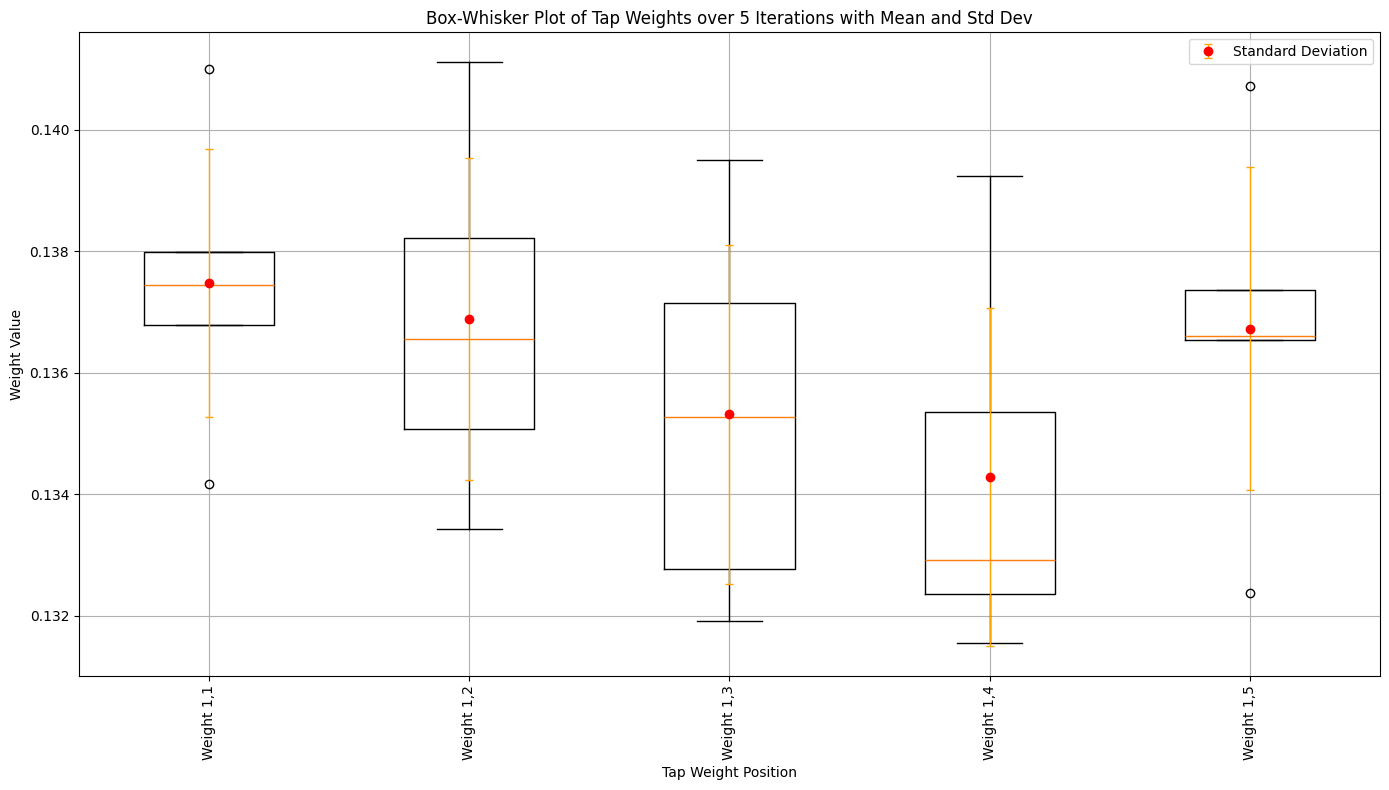

In [10]:
tap_weights = []
itterations = 5
filter_width = 5
desired_image = raw_image - np.mean(raw_image)

for i in range(itterations):
    
    noise_level = 20
    noise = np.random.normal(-noise_level, noise_level, desired_image.shape)
    noisy_image = raw_image + noise

    # Convert noisy_image to uint8 and clip values to be in the valid range [0, 255]
    noisy_image_uint8 = np.clip(noisy_image, 0, 255).astype(np.uint8)

    input_image = desired_image + noise
    filtered_image, error_history, weights = lms_filter_1d(input_image, desired_image, filter_width, 0.000001)
    tap_weights.append(weights)

tap_weights = np.array(tap_weights)  # Shape should be (100, 7) after this conversion

# Transpose to separate each tap weight
tap_weights_reshaped = tap_weights.reshape(itterations, filter_width).T 

mean_values = np.mean(tap_weights_reshaped, axis=1)
std_values = np.std(tap_weights_reshaped, axis=1) 
print(mean_values)
print(std_values)

# Create the boxplot
plt.figure(figsize=(14, 8))
plt.boxplot(tap_weights_reshaped.T, tick_labels=[f'Weight {i//filter_width+1},{i%filter_width+1}' for i in range(filter_width)])
plt.xticks(rotation=90)  # Rotate labels for readability

# Overlay the mean and standard deviation as scatter points
# plt.scatter(range(1, filter_width ** 2 +1), mean_values, color='red', marker='o', label='Mean')
plt.errorbar(range(1, filter_width + 1), mean_values, yerr=std_values, fmt='o', color='red', 
             ecolor='orange', elinewidth=1, capsize=3, label='Standard Deviation')

# Add labels and title
plt.xlabel(f"Tap Weight Position")
plt.ylabel("Weight Value")
plt.title(f"Box-Whisker Plot of Tap Weights over {itterations} Iterations with Mean and Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Same weights and noise, different image

(337, 600)


(np.float64(-0.5), np.float64(599.5), np.float64(336.5), np.float64(-0.5))

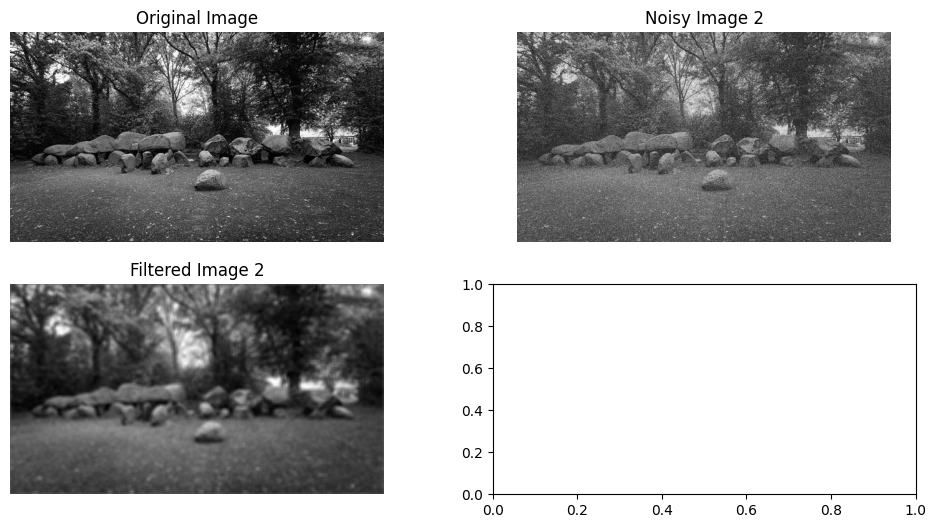

In [11]:
noise_level = 20
noise = np.random.normal(-noise_level, noise_level, (700, 700))
raw_image_shape = raw_image.shape
noise_1 = noise[:raw_image_shape[0], :raw_image_shape[1]]
noisy_image = raw_image + noise_1

# Convert noisy_image to uint8 and clip values to be in the valid range [0, 255]
noisy_image_uint8 = np.clip(noisy_image, 0, 255).astype(np.uint8)
input_image = desired_image + noise_1
filtered_image, error_history, weights = lms_filter_2d(input_image, desired_image, 7, 0.000001)

image_2 = Image.open('test_image_2_bw.jpg')

raw_image_2 = np.array(image_2)
print(raw_image_2.shape)
desired_image_2 = raw_image_2 - np.mean(raw_image_2)

raw_image_shape_2 = raw_image_2.shape
noise_2 = noise[:raw_image_shape_2[0], :raw_image_shape_2[1]]
noisy_image_2 = raw_image_2 + noise_2

input_image_2 = desired_image_2 + noise_2
filtered_image_2, _, _ = lms_filter_2d(input_image_2, desired_image_2, 7, 0.000001, weights, False, False)
filtered_image_2 += np.mean(raw_image_2)

# Display the image
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].imshow(image_2, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_2, cmap='gray')
ax[0, 1].set_title('Noisy Image 2')
ax[0, 1].axis('off')

ax[1, 0].imshow(filtered_image_2, cmap='gray')
ax[1, 0].set_title('Filtered Image 2')
ax[1, 0].axis('off')


# Another method of detecting the error.
It seems the filtered image is a little better than the noisy image.

In [12]:
# Ensure both images are in the same range
image_2_array = np.array(image_2, dtype=np.float64)
noise_image_2_array = np.array(noisy_image_2, dtype=np.float64)
filtered_image_2_array = np.array(filtered_image_2, dtype=np.float64)

# Calculate the normalized difference
normalized_difference = np.abs(image_2_array - filtered_image_2_array) / np.max(np.abs(image_2_array))
normalized_difference_noisy = np.abs(image_2_array - noise_image_2_array) / np.max(np.abs(image_2_array))
print("difference between orginal and noisy image", np.mean(normalized_difference_noisy))
print("difference between orginal and filtered: ", np.mean(normalized_difference))


difference between orginal and noisy image 0.0916496021573117
difference between orginal and filtered:  0.09056557507403434


# Using a gradient image

(256, 256)


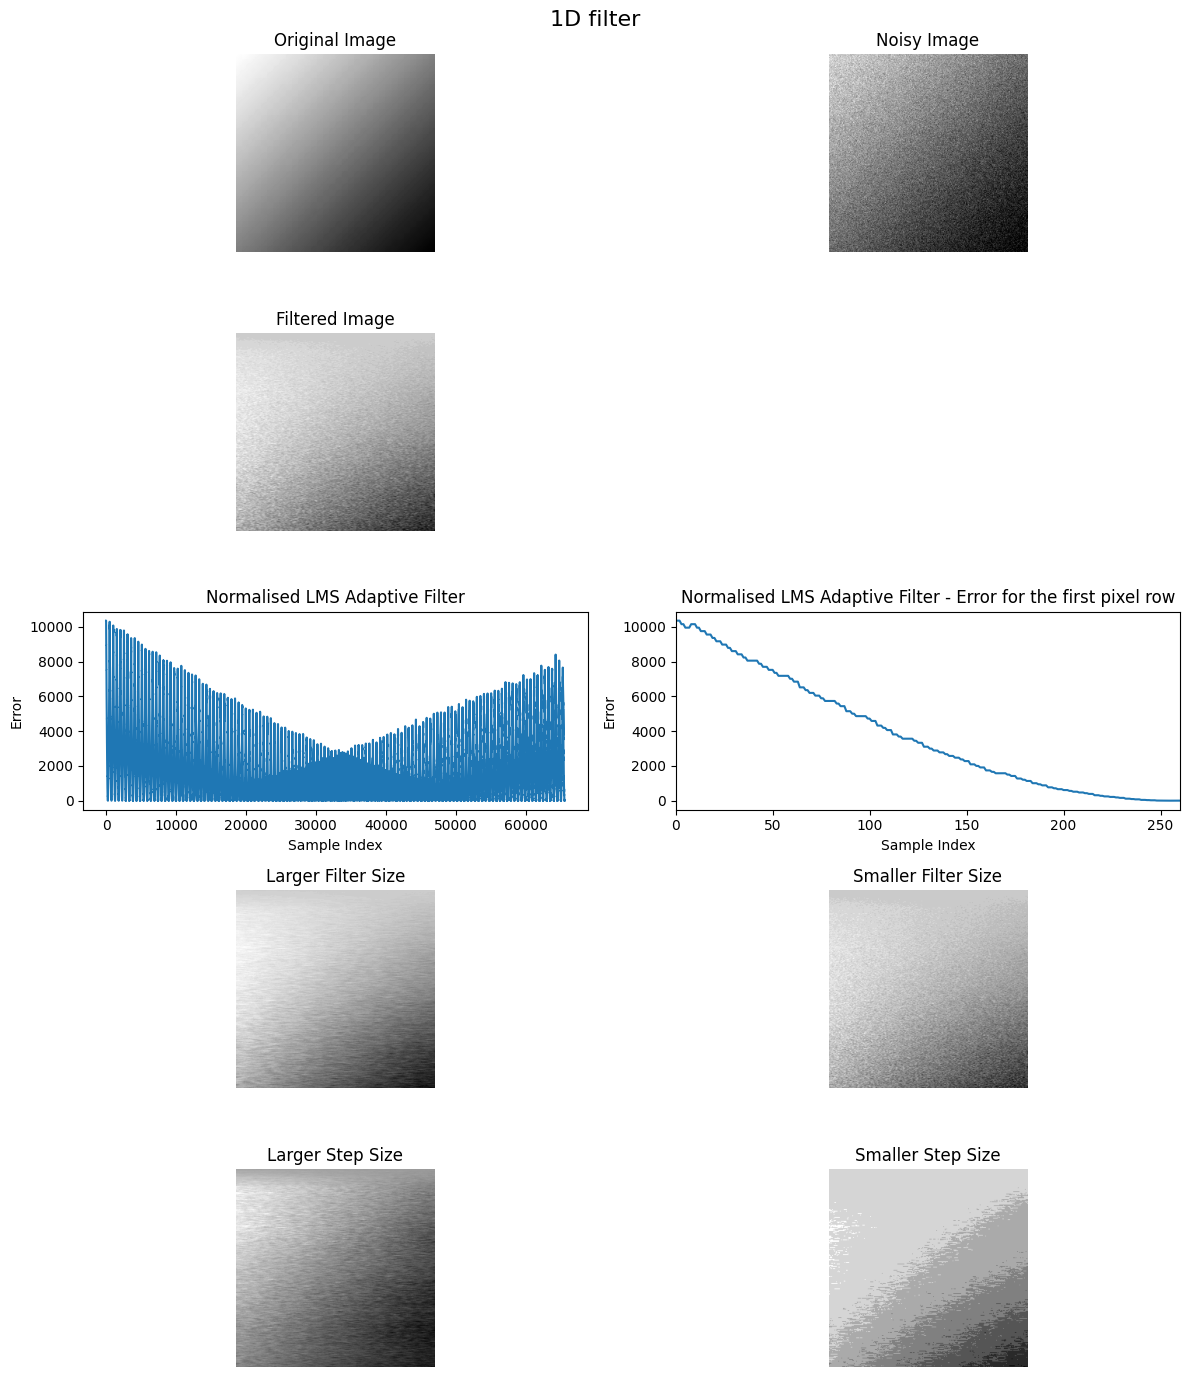

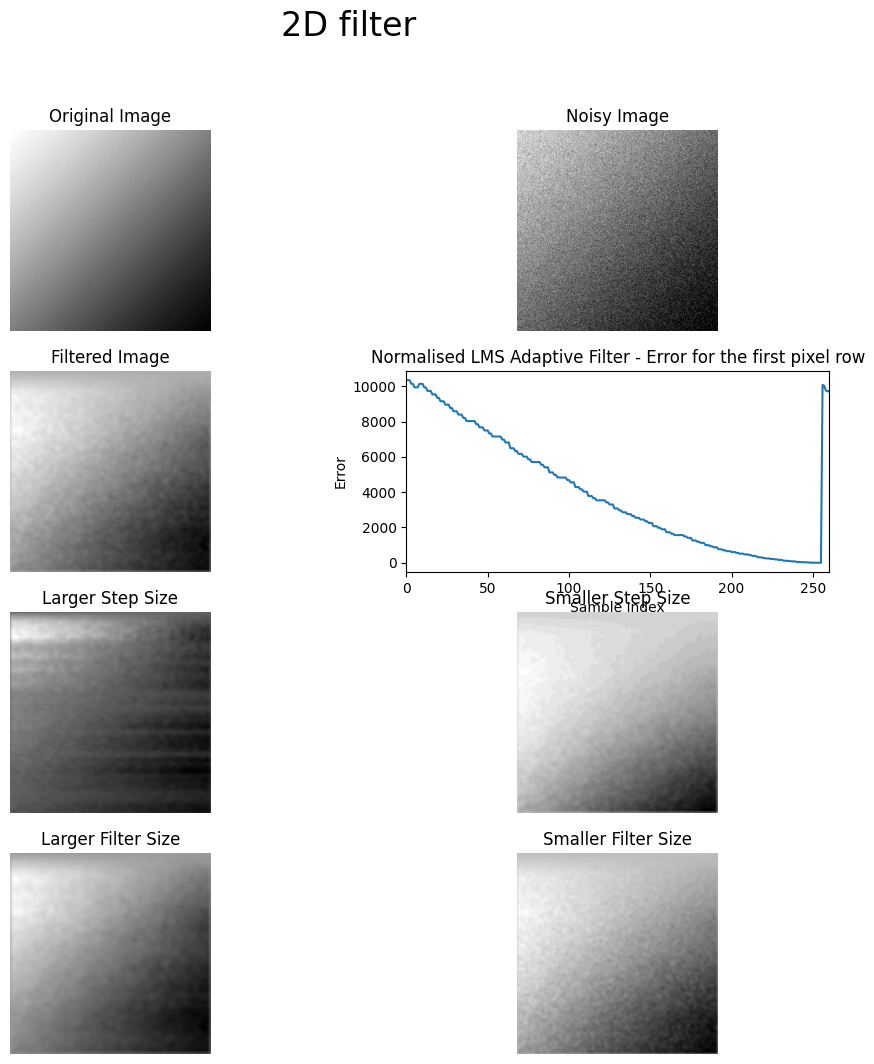

In [13]:
image = Image.open('gradient_bw.jpg')

raw_image = np.array(image)
print(raw_image.shape)
desired_image = raw_image - np.mean(raw_image)
noise_level = 20
noise = np.random.normal(-noise_level, noise_level, desired_image.shape)
noisy_image = raw_image + noise

# Convert noisy_image to uint8 and clip values to be in the valid range [0, 255]
noisy_image_uint8 = np.clip(noisy_image, 0, 255).astype(np.uint8)

input_image = desired_image + noise

filtered_image, error_history, weights = lms_filter_1d(input_image, desired_image, 3, 0.000001, None)
larger_step, _,_ = lms_filter_1d(input_image, desired_image, 7, 0.00001, None, True)
smaller_step, _,_ = lms_filter_1d(input_image, desired_image, 7, 0.0000001, None)
larger_filter, _,_ = lms_filter_1d(input_image, desired_image, 9, 0.000001, None)
smaller_filter, _,_ = lms_filter_1d(input_image, desired_image, 2, 0.000001, None)

# Reshape the output to the original image shape
output_image = filtered_image.reshape(raw_image.shape)
output_image += np.mean(raw_image)
# Clip values to be in the valid range [0, 255] and convert to uint8
output_image_uint8 = np.clip(output_image, 0, 255).astype(np.uint8)

larger_step = larger_step.reshape(raw_image.shape)
larger_step += np.mean(raw_image)
larger_step = np.clip(larger_step, 0, 255).astype(np.uint8)

smaller_step = smaller_step.reshape(raw_image.shape)
smaller_step += np.mean(raw_image)
smaller_step = np.clip(smaller_step, 0, 255).astype(np.uint8)

larger_filter = larger_filter.reshape(raw_image.shape)
larger_filter += np.mean(raw_image)
larger_filter = np.clip(larger_filter, 0, 255).astype(np.uint8)

smaller_filter = smaller_filter.reshape(raw_image.shape)
smaller_filter += np.mean(raw_image)
smaller_filter = np.clip(smaller_filter, 0, 255).astype(np.uint8)

# Display the original, noisy, and output images
fig, ax = plt.subplots(5, 2, figsize=(12, 14))
fig.suptitle('1D filter', fontsize=16)
ax[0, 0].imshow(raw_image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_uint8, cmap='gray')
ax[0, 1].set_title('Noisy Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(output_image_uint8, cmap='gray')
ax[1, 0 ].set_title('Filtered Image')
ax[1, 0].axis('off')

ax[1, 1].axis('off')

ax[2, 0].plot(error_history, label='Errors')
ax[2, 0].set_xlabel('Sample Index')
ax[2, 0].set_ylabel('Error')
ax[2, 0].set_title('Normalised LMS Adaptive Filter')

ax[2, 1].plot(error_history, label='Errors')
ax[2, 1].set_xlabel('Sample Index')
ax[2, 1].set_ylabel('Error')
ax[2, 1].set_title('Normalised LMS Adaptive Filter - Error for the first pixel row')
ax[2, 1].set_xlim(0, 260)

# Plot larger_filter
ax[3, 0].imshow(larger_filter, cmap='gray')
ax[3, 0].set_title('Larger Filter Size')
ax[3, 0].axis('off')

# Plot smaller_filter
ax[3, 1].imshow(smaller_filter, cmap='gray')
ax[3, 1].set_title('Smaller Filter Size')
ax[3, 1].axis('off')

# Plot larger_step
ax[4, 0].imshow(larger_step, cmap='gray')
ax[4, 0].set_title('Larger Step Size')
ax[4, 0].axis('off')

# Plot smaller_step
ax[4, 1].imshow(smaller_step, cmap='gray')
ax[4, 1].set_title('Smaller Step Size')
ax[4, 1].axis('off')

fig.tight_layout()
plt.show()

filtered_image, error_history, weights = lms_filter_2d(input_image, desired_image, 7, 0.000001, None)
larger_step, _,_ = lms_filter_2d(input_image, desired_image, 7, 0.00001, None, True)
smaller_step, _,_ = lms_filter_2d(input_image, desired_image, 7, 0.0000001, None)
larger_filter, _,_ = lms_filter_2d(input_image, desired_image, 9, 0.000001, None)
smaller_filter, _,_ = lms_filter_2d(input_image, desired_image, 5, 0.000001, None)

# Reshape the output to the original image shape
output_image = filtered_image.reshape(raw_image.shape)
output_image += np.mean(raw_image)
# Clip values to be in the valid range [0, 255] and convert to uint8
output_image_uint8 = np.clip(output_image, 0, 255).astype(np.uint8)

larger_step = larger_step.reshape(raw_image.shape)
larger_step += np.mean(raw_image)
larger_step = np.clip(larger_step, 0, 255).astype(np.uint8)

smaller_step = smaller_step.reshape(raw_image.shape)
smaller_step += np.mean(raw_image)
smaller_step = np.clip(smaller_step, 0, 255).astype(np.uint8)

larger_filter = larger_filter.reshape(raw_image.shape)
larger_filter += np.mean(raw_image)
larger_filter = np.clip(larger_filter, 0, 255).astype(np.uint8)

smaller_filter = smaller_filter.reshape(raw_image.shape)
smaller_filter += np.mean(raw_image)
smaller_filter = np.clip(smaller_filter, 0, 255).astype(np.uint8)

# Display the original, noisy, and output images
fig, ax = plt.subplots(4, 2, figsize=(12, 12))
fig.suptitle('2D filter', fontsize=24)
ax[0, 0].imshow(raw_image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_uint8, cmap='gray')
ax[0, 1].set_title('Noisy Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(output_image_uint8, cmap='gray')
ax[1, 0 ].set_title('Filtered Image')
ax[1, 0].axis('off')

ax[1, 1].plot(error_history, label='Errors')
ax[1, 1].set_xlabel('Sample Index')
ax[1, 1].set_ylabel('Error')
ax[1, 1].set_title('Normalised LMS Adaptive Filter - Error for the first pixel row')
ax[1, 1].set_xlim(0, 260)

# Plot larger_step
ax[2, 0].imshow(larger_step, cmap='gray')
ax[2, 0].set_title('Larger Step Size')
ax[2, 0].axis('off')

# Plot smaller_step
ax[2, 1].imshow(smaller_step, cmap='gray')
ax[2, 1].set_title('Smaller Step Size')
ax[2, 1].axis('off')

# Plot larger_filter
ax[3, 0].imshow(larger_filter, cmap='gray')
ax[3, 0].set_title('Larger Filter Size')
ax[3, 0].axis('off')

# Plot smaller_filter
ax[3, 1].imshow(smaller_filter, cmap='gray')
ax[3, 1].set_title('Smaller Filter Size')
ax[3, 1].axis('off')

plt.show()

# Audio file
## This one works the best!

In [14]:
from scipy.io import wavfile
from IPython import display
import numpy as np

# Read the WAV file
sample_rate, normal_audio = wavfile.read('normal_audio.wav')

noise_level = 200
noise = np.random.normal(-noise_level, noise_level, normal_audio.shape)
noisy_audio = normal_audio + noise

print("normal")
display.display(display.Audio(data=normal_audio, rate=sample_rate))
print("noisy")
display.display(display.Audio(data=noisy_audio, rate=sample_rate))

smallest_error = 1000000000000
best_learning_rate = 0
best_filter_size = 0

# for learning_rate in range(3):
#     for filter_size in range(5, 20):
#         filtered_audio, error_history, weights = lms_filter_1d(noisy_audio, normal_audio, filter_size, 0.000000001 * (0.1**learning_rate), None, False)
#         print(f"Learning rate: {0.000000001 * (0.1**learning_rate)}, Filter size: {filter_size}, Average error: {np.mean(error_history)}")
#         display.display(display.Audio(data=filtered_audio, rate=sample_rate))
#         if np.mean(error_history) < smallest_error:
#             smallest_error = np.mean(error_history)
#             best_learning_rate = 0.000000001 * (0.1**learning_rate)
#             best_filter_size = filter_size

print(f"Best learning rate: {best_learning_rate}, Best filter size: {best_filter_size}, Smallest error: {smallest_error}")
filtered_audio, error_history, weights = lms_filter_1d(noisy_audio, normal_audio, 12, 0.000000001, None, False)
display.display(display.Audio(data=filtered_audio, rate=sample_rate))

normal


noisy


Best learning rate: 0, Best filter size: 0, Smallest error: 1000000000000


# Large values sine wave

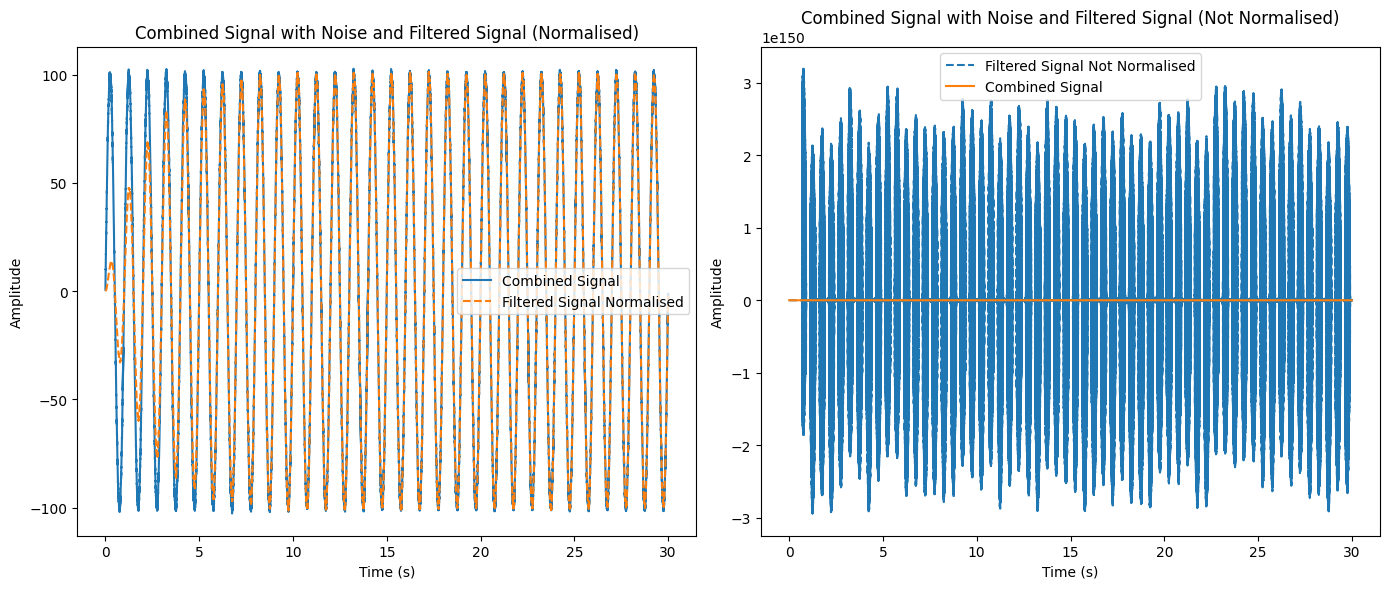

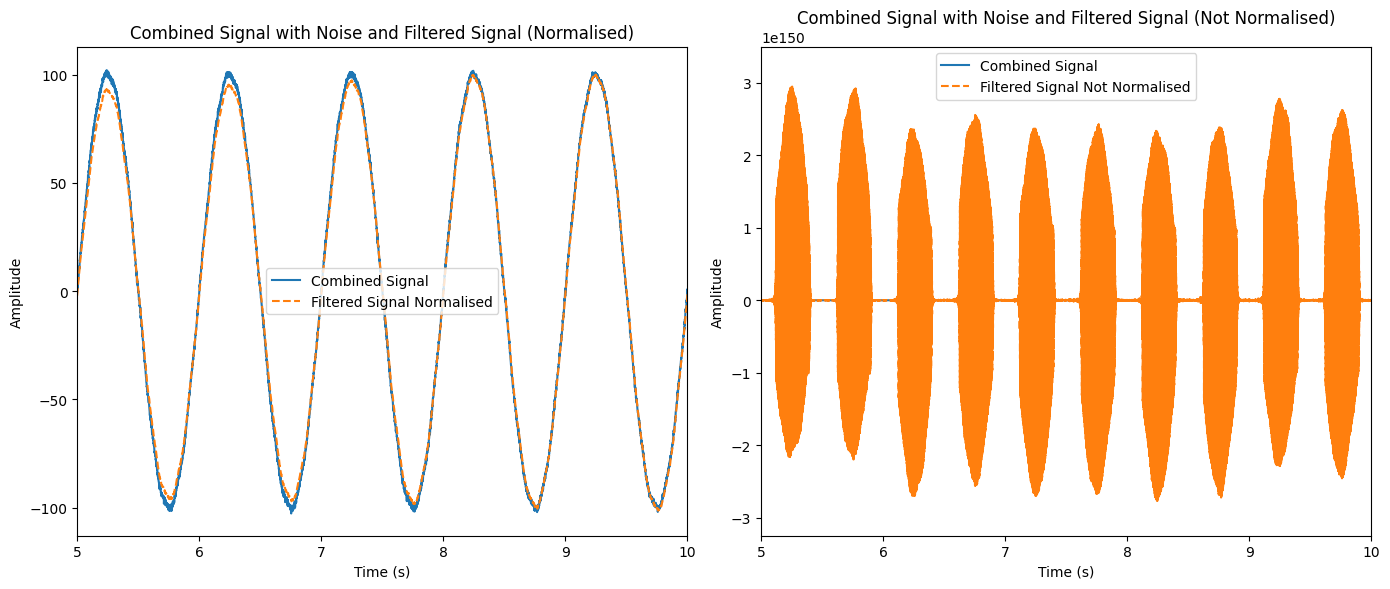

In [15]:
def lms_filter_1d_normalised_or_not(input_image, desired_image, filter_size=3, learning_rate=0.01, start_weights=None, Alternate=True, Normalised=True):
    if start_weights is not None:
        weights = start_weights
    else:
        weights = np.zeros(filter_size)
    
    if Alternate:
        input_image = mirror_alternate_rows(input_image)
        desired_image = mirror_alternate_rows(desired_image)
    
    if len(input_image.shape) > 1:
        error_history = np.zeros(input_image.shape[0] * input_image.shape[1])
    else:
        error_history = np.zeros(len(input_image))
        
    output_weights = None
    
    input_flat = input_image.flatten()
    desired_flat = desired_image.flatten()
    output_image_flat = np.zeros_like(input_flat)
    input_buffer = np.zeros(filter_size)
    
    for i in range(len(input_flat)):
        # Update input buffer with the current measurement
        input_buffer = np.roll(input_buffer, -1)  # Shift left
        input_buffer[-1] = input_flat[i]         # Add new measurement at the end

        # Desired output at this time step
        d_k = desired_flat[i]

        # Calculate the output y(k) = w.T * x (dot product of weights and input buffer)
        y_k = np.dot(weights, input_buffer)

        # Calculate the error e(k) = d(k) - y(k)
        e_k = (d_k - y_k)

        if e_k < 10 and output_weights is None:
               output_weights = weights
           
        if abs(e_k) < 1e-10:
            if e_k > 0:
                e_k = 0.1e-10
            else:
                e_k = -0.1e-10
        
        if abs(e_k) > 1e150:
            if e_k > 0:
                e_k = 1e150
            else:
                e_k = -1e150
                
        # Update weights with w(k+1) = w(k) + μ * e(k) * x
        # weights += learning_rate * e_k * input_buffer

        if Normalised:
            weights += (learning_rate/ (1e-3 + (abs(input_buffer) ** 2)))* e_k * input_buffer
        else:
            weights += learning_rate * e_k * input_buffer

        # Store results
        output_image_flat[i] = y_k
        error_history[i] = e_k ** 2

    if len(input_image.shape) > 1:
        return mirror_alternate_rows(np.reshape(output_image_flat, (input_image.shape[0], input_image.shape[1]))), error_history, output_weights 
    else:
        return output_image_flat, error_history, output_weights

# Parameters for the sine waves
frequency1 = 1  # Frequency of the first sine wave (Hz)
frequency2 = 10  # Frequency of the second sine wave (Hz)
amplitude1 = 100  # Amplitude of the first sine wave
amplitude2 = 1   # Amplitude of the second sine wave
duration = 30     # Duration of the sine waves (seconds)
sample_rate = 1000  # Sampling rate (samples per second)

# Generate time values
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate sine waves
sine_wave1 = amplitude1 * np.sin(2 * np.pi * frequency1 * t)
sine_wave2 = amplitude2 * np.sin(2 * np.pi * frequency2 * t)

# Create small normally distributed noise
noise = np.random.normal(0, 0.7, sine_wave1.shape)

# Sum the sine waves and add noise
combined_signal = sine_wave1 + sine_wave2 + noise

filtered_signal_normalised, error_history, weights = lms_filter_1d_normalised_or_not(combined_signal, sine_wave1, 5, 0.0001, None, False, True)
filtered_signal_not_normalised, error_history, weights = lms_filter_1d_normalised_or_not(combined_signal, sine_wave1, 5, 0.0001, None, False, False)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, combined_signal, label='Combined Signal')
plt.plot(t, filtered_signal_normalised, label='Filtered Signal Normalised', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Combined Signal with Noise and Filtered Signal (Normalised)')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(t, filtered_signal_not_normalised, label='Filtered Signal Not Normalised', linestyle='--')
plt.plot(t, combined_signal, label='Combined Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Combined Signal with Noise and Filtered Signal (Not Normalised)')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, combined_signal, label='Combined Signal')
plt.plot(t, filtered_signal_normalised, label='Filtered Signal Normalised', linestyle='--')
plt.xlim(5, 10)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Combined Signal with Noise and Filtered Signal (Normalised)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, combined_signal, label='Combined Signal')
plt.plot(t, filtered_signal_not_normalised, label='Filtered Signal Not Normalised', linestyle='--')
plt.xlim(5, 10)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Combined Signal with Noise and Filtered Signal (Not Normalised)')
plt.legend()

plt.tight_layout()
plt.show()


# Optional 1 and partial Optional 2

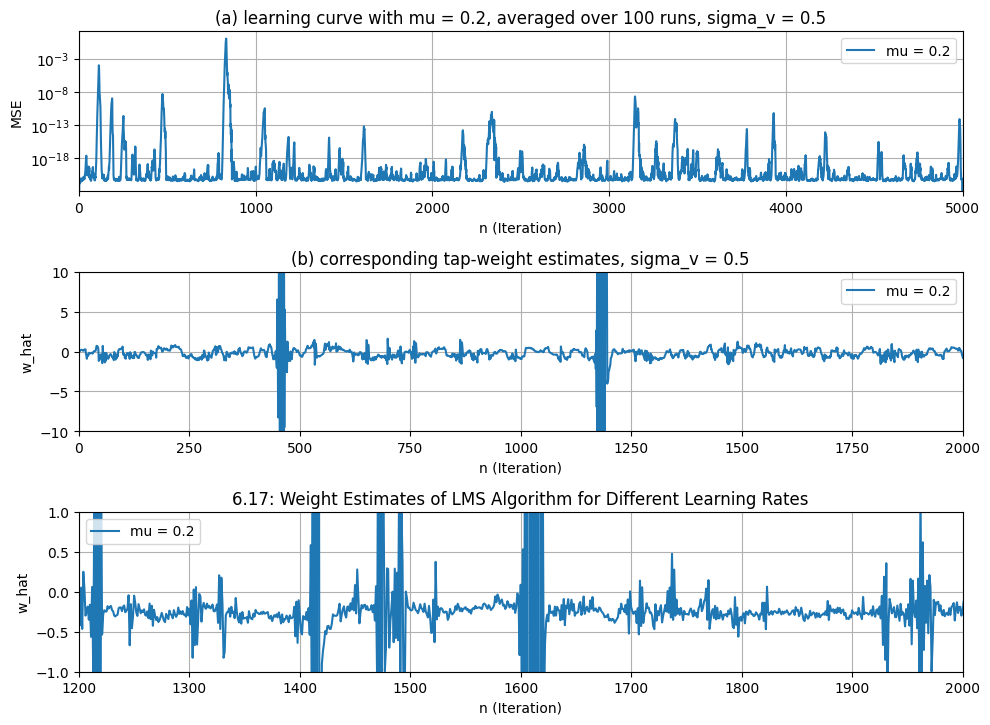

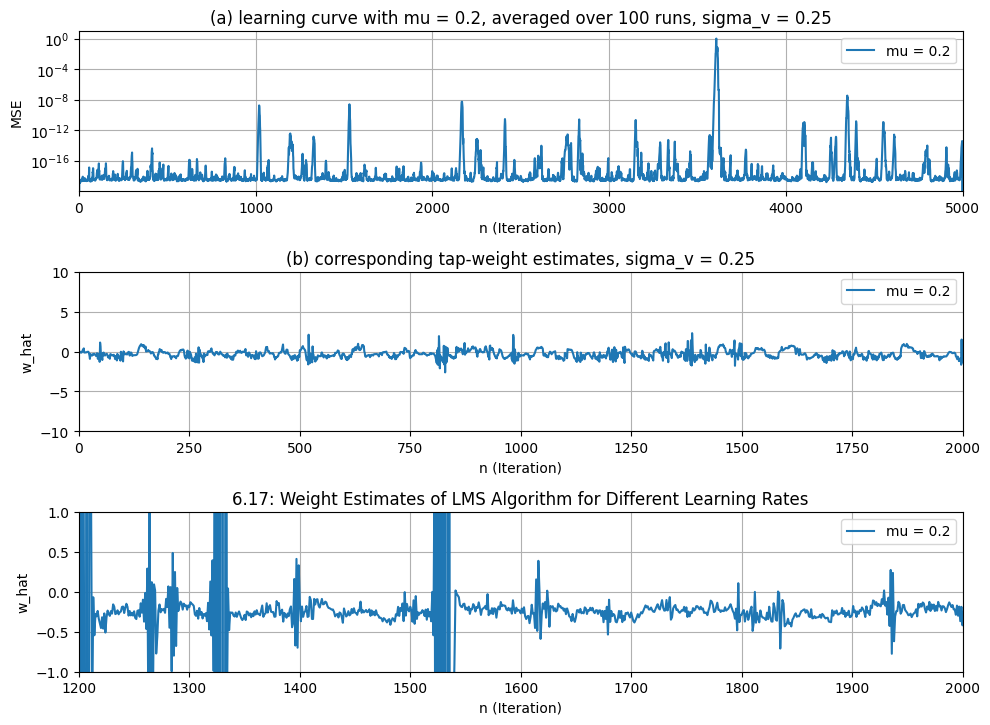

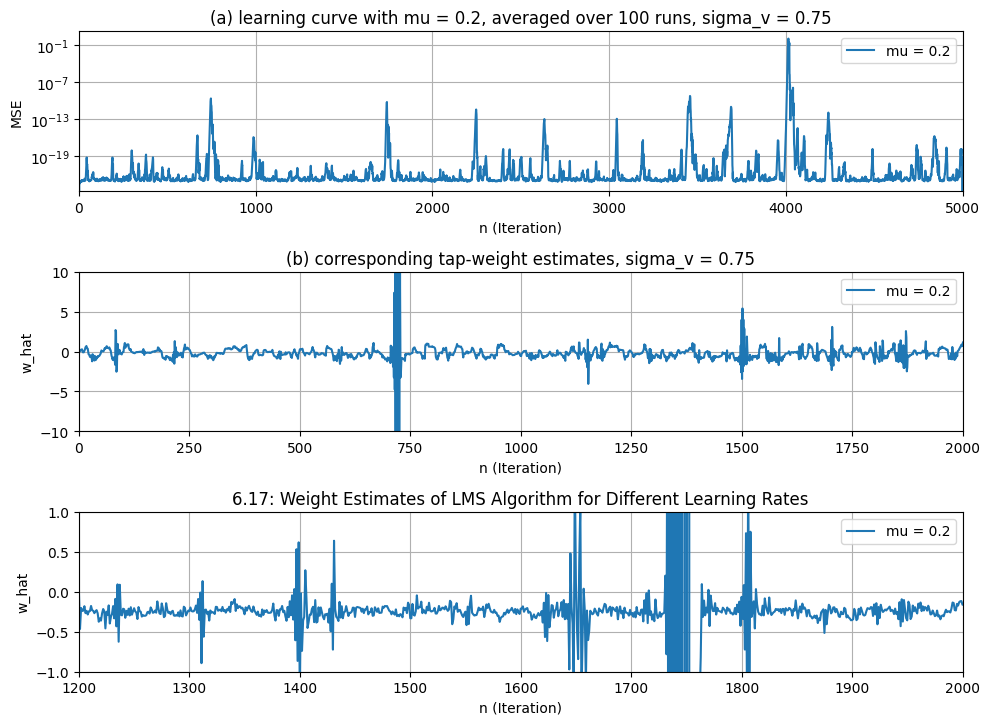

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def lms_algorithm(mu, num_samples, seed=1, a1 = 0.1, a2 = -0.8, sigma_v = 0.5):
    if seed != 1:
        np.random.seed(seed)

    # Generate AR process data u(n) = -a * u(n-1) + v(n)
    u = np.zeros(num_samples)
    white_noise = np.sqrt(sigma_v * (1 - a1 ** 2)) # White noise variance according to formula 6.110
    v = np.random.normal(0, white_noise, num_samples)  # White noise

    for n in range(2, num_samples):
        u[n] = (-a1 * u[n-1]) - (a2 * u[n-2]) + v[n]

    # LMS Algorithm to estimate parameter 'a'
    w_hat = np.zeros(num_samples)  # Initialize weight estimate
    # w_actual = -a  # Actual value of -a for reference

    # Calculate mean square error
    mse = np.zeros(num_samples)
    w_hat_history = []
    for n in range(1, num_samples - 1):
        # Prediction error f(n) = u(n) - w_hat(n) * u(n-1)
        f_n = u[n] - w_hat[n] * u[n-1]
        # Weight update with overflow check
        w_hat[n + 1] = w_hat[n] + mu * u[n - 1] * f_n
        if abs(w_hat[n + 1]) > 1e150:
            w_hat[n + 1] = np.sign(w_hat[n + 1]) * 1e150
        # Mean square error
        mse[n] = f_n ** 2
        w_hat_history.append(w_hat[n])

    return mse, w_hat_history
def assigment_10_a(sigma_v = 0.5):
    mu_values = [0.2]
    mse_all_runs = [[] for _ in range(len(mu_values))]
    w_hat_all_runs = [[] for _ in range(len(mu_values))]

    for _ in range(100):
        for (i, mu) in enumerate(mu_values):
            mse, w_hat_n = lms_algorithm(mu, 5000)
            mse_all_runs[i].append(mse)
            w_hat_all_runs[i].append(w_hat_n)

    # Plot all three in the same chart
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

    # Plot MSE
    for i, mu in enumerate(mu_values):
        average_mse = np.mean(mse_all_runs[i], axis=0)
        average_mse = average_mse / np.max(average_mse)  # Normalize experimental MSE
        axs[0].plot(average_mse, label=f'mu = {mu}')

    axs[0].set_xlim(0, 5000)
    axs[0].set_xlabel('n (Iteration)')
    axs[0].set_ylabel('MSE')
    axs[0].set_yscale('log')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].set_title(f'(a) learning curve with mu = 0.2, averaged over 100 runs, sigma_v = {sigma_v}')

    # Plot w_hat_history
    for i, mu in enumerate(mu_values):    
        axs[1].plot(w_hat_all_runs[i][0], label=f'mu = {mu}')
        average_w_hat = np.mean(w_hat_all_runs[i], axis=0)
        axs[2].plot(average_w_hat, label=f'mu = {mu}')

    axs[1].set_xlim(0, 2000)
    axs[1].set_ylim(-10, 10)
    axs[1].set_xlabel('n (Iteration)')
    axs[1].set_ylabel('w_hat')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_title(f'(b) corresponding tap-weight estimates, sigma_v = {sigma_v}')

    # zoom in further to see the convergence
    axs[2].set_xlim(1200, 2000)
    axs[2].set_ylim(-1, 1)
    axs[2].set_xlabel('n (Iteration)')
    axs[2].set_ylabel('w_hat')
    axs[2].legend()
    axs[2].grid(True)
    axs[2].set_title('6.17: Weight Estimates of LMS Algorithm for Different Learning Rates')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

assigment_10_a(0.5)
assigment_10_a(0.25)
assigment_10_a(0.75)